## Bert - POC

In [3]:
import numpy as np
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
class BertBaseMultilingualEmbeddingApi:
    
    def __init__(self, model_name="bert-base-multilingual-cased", cuda=True):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        
        self.tokens_tensor = None
        self.segments_tensor = None
        
        self.encoded_layers_ = None
        self.token_embeddings_ = None
        
    def _tokenize_text(self, text):
        marked_text = "[CLS] " + text + " [SEP]"
        tokenized_text = self.tokenizer.tokenize(marked_text)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)
        
        self.tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)
        self.segments_tensor = torch.tensor([segments_ids]).to(self.device)
    
    def _evaluate(self):
        with torch.no_grad():
            encoded_layers, _ = self.model(self.tokens_tensor, self.segments_tensor)
        self.encoded_layers_ = encoded_layers
    
    def _generate_token_embeddings(self, batch_i=0):
        """
        Convert the hidden state embeddings into single token vectors
        Holds the list of 12 layer embeddings for each token
        Will have the shape: [# tokens, # layers, # features]
        """
        token_embeddings = [] 
        # For each token in the sentence...
        for token_i in range(len(self.encoded_layers_[-1][batch_i])):
            # Holds 12 layers of hidden states for each token 
            hidden_layers = [] 
            # For each of the 12 layers...
            for layer_i in range(len(self.encoded_layers_)):
            # Lookup the vector for `token_i` in `layer_i`
                vec = self.encoded_layers_[layer_i][batch_i][token_i]
                hidden_layers.append(vec)
            token_embeddings.append(hidden_layers)
        self.token_embeddings_ = token_embeddings
    
    def feed_forward(self, sentence):
        self._tokenize_text(sentence)
        self._evaluate()
        self._generate_token_embeddings()
    
    def create_word_embedding_(self, how="cat_last_4"):
        if how == "cat_last_4":
            return [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in self.token_embeddings_]
        elif how == "sum_last_4":
            return [torch.sum(torch.stack(layer)[-4:], 0) for layer in self.token_embeddings_]
        else:
            print("Redefine `how` parameter")
        
    def create_sentence_embedding_(self, how="mean_last_layer"):
        if how == "mean_last_layer":
            return torch.mean(self.encoded_layers_[-1], 1).squeeze()
        else:
            print("Redefine `how` parameter")
            
    def print_dimensions_(self):
        print ("Number of layers:", len(self.encoded_layers_))
        layer_i = 0
        print ("Number of batches:", len(self.encoded_layers_[layer_i]))
        batch_i = 0
        print ("Number of tokens:", len(self.encoded_layers_[layer_i][batch_i]))
        token_i = 0
        print ("Number of hidden units:", len(self.encoded_layers_[layer_i][batch_i][token_i]))
        
    def plot_embedding_hist(self, vec):
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 8))
        sns.distplot(vec)
        plt.show()

## Text Preprocessing

In [13]:
import codecs
from pprint import pprint
NUMBER_OF_FILES_TO_OPEN = 1

In [16]:
corpusNews = list()
for i in range(0,NUMBER_OF_FILES_TO_OPEN):
    f = codecs.open("doc"+str(i+1), "r", encoding = 'utf-8')
    for line in f:
        corpusNews.append(line)
    f.close()
pprint(corpusNews[0])

('Tomasza <Entity name="Tomasz Sekielski" type="person" '
 'category="dziennikarze">Sekielskiego</Entity> oburzyła wypowiedź prof. '
 'Mariana Filara. Wybitny prawnik stwierdził, że nawet jeśli znalezione w celi '
 'Mariusza T. to prowokacja - postąpiono słusznie. - Nie wiem, co się stało '
 'profesorowi. Proponuje bardzo niebezpieczną drogę. Mariusz T. nigdy nie '
 'powinien wyjść na wolność. Ale nie można w tym celu łamać prawa - mówił '
 '<Entity name="Tomasz Sekielski" type="person" '
 'category="dziennikarze">Sekielski</Entity> w TOK FM. "Człowiek, który '
 'zdecydował o podrzuceniu Mariuszowi T. do celi kompromitujących materiałów, '
 'postawił na szali jedne wartości przeciw drugim. Postawił naruszenie prawa '
 'przeciw ludzkiemu bezpieczeństwu. W mojej ocenie wybrał słusznie" - tak w '
 'wywiadzie dla "Gazety Wyborczej" prof. <Entity name="Marian Filar" '
 'type="person" category="muzycy">Marian Filar</Entity> komentował informacje '
 'o znalezieniu w celi Mariusza T. materiałó

Below are functions from Piter, that I did not changed (but use it differently):

In [25]:
def find_annotations(document : str):
    '''
    Searches for all occurances of '<' and '>' in the document.
    Returns lists of indexes of occurances opening for '<' and closing for '>'
    '''
    i = 0
    opening = list()
    closing = list()
    while i != -1:
        i = document.find('<', i)
        opening.append(i)
        if i == -1:
            closing.append(-1)
            break
        i = document.find('>', i)
        closing.append(i)
    closing = [cl + 1 for cl in closing]
    closing[-1] = -1
    return(opening, closing)

def get_annotation_values(text : str): # jest typ nie type, bo type jest zarezerwowana nazwa, nie jestem uposledzony
    '''
    Returns a dict consisting annotation values {'name', 'typ', 'category'} for first occuring annotation
    in the text.
    '''
    name_start = text.find('name=') + len('name=\"')
    name_end = text.find('\"', name_start)
    typ_start = text.find('type=', name_end) + len('type=\"')
    typ_end = text.find('\"', typ_start)
    category_start = text.find('category', typ_end) + len('category=\"')
    category_end = text.find('\"', category_start)
    return({'name' : text[name_start:name_end], 'typ' : text[typ_start:typ_end],
               'category' : text[category_start:category_end]})

def exclude_vectors_for_person(list_of_vectors, person):
    '''
    list_of_vectors - return value from exclude_sentence_vectors()
    person - name of person from people_dict
    '''
    l = list()
    for el in list_of_vectors:
        if el[1] == person:
            l.append(el[0])
    return l

And our function for sentences:

In [26]:
def exclude_sentence_vectors(text):
    people_dict = {}
    sentences = text.split(".")
    contexts = []
    for sentence in sentences:
        opn, cls = find_annotations(sentence)
        if opn[0] != -1:
            annotation = get_annotation_values(sentence)
            sentence = sentence[0:opn[0]] + sentence[cls[-2]:]
            contexts.append([sentence, annotation["name"]])
            try:
                people_dict[annotation["category"]].add(annotation["name"])
            except KeyError:
                people_dict[annotation["category"]] = {annotation["name"]}
    return contexts, people_dict


In [27]:
vectors, people_dict = exclude_sentence_vectors(corpusNews[0])
print(vectors)
print(people_dict)

[['Tomasza  oburzyła wypowiedź prof', 'Tomasz Sekielski'], [' Ale nie można w tym celu łamać prawa - mówił  w TOK FM', 'Tomasz Sekielski'], ['  komentował informacje o znalezieniu w celi Mariusza T', 'Marian Filar'], [' Słowa prawnika zaskoczyły i oburzyły ', 'Tomasz Sekielski'], [' Zdaniem  prawnik z UMK w Toruniu proponuje "bardzo niebezpieczną drogę"', 'Tomasz Sekielski'], [' - Ale nie można w tym celu łamać prawa, bo za chwilę w podobnej sytuacji może się znaleźć nie tylko morderca-pedofil - powiedział ', 'Tomasz Sekielski']]
{'dziennikarze': {'Tomasz Sekielski'}, 'muzycy': {'Marian Filar'}}


In [29]:
print(exclude_vectors_for_person(vectors, "Tomasz Sekielski"))

['Tomasza  oburzyła wypowiedź prof', ' Ale nie można w tym celu łamać prawa - mówił  w TOK FM', ' Słowa prawnika zaskoczyły i oburzyły ', ' Zdaniem  prawnik z UMK w Toruniu proponuje "bardzo niebezpieczną drogę"', ' - Ale nie można w tym celu łamać prawa, bo za chwilę w podobnej sytuacji może się znaleźć nie tylko morderca-pedofil - powiedział ']


## Example usage

1. Create API object

In [5]:
bert = BertBaseMultilingualEmbeddingApi()

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.
100%|██████████| 662804195/662804195 [10:41<00:00, 1032855.28B/s]


2. Create sentence and pass to feed_forward method

In [6]:
sentence = "Oszczędnością i pracą ludzie się bogacą."
bert.feed_forward(sentence)

3. Generate word/sentence embedding, specify `how`

In [7]:
words_embeddings = bert.create_word_embedding_(how = "sum_last_4")

In [8]:
sent_embedding = bert.create_sentence_embedding_()

4. Visualize tensor

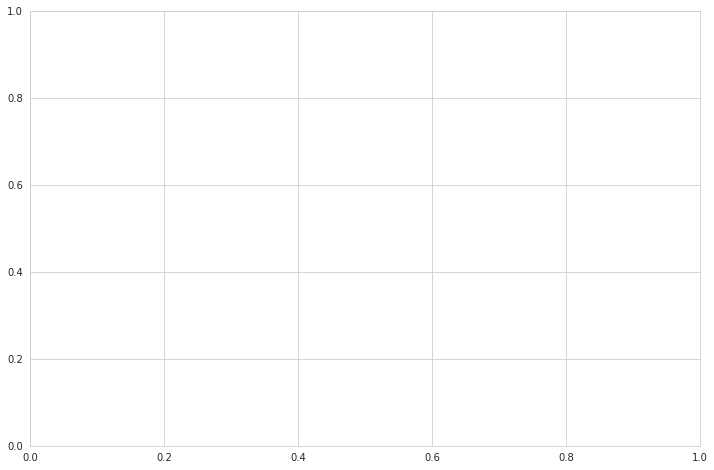

In [12]:
bert.plot_embedding_hist(sent_embedding)

## Visualize embeddings in tensorboard

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [10]:
LOG_DIR = 'minimalsample'
NAME_TO_VISUALISE_VARIABLE = "example_embeddings"
path_for_mnist_metadata =  'metadata.tsv'

In [11]:
token_embeddings_np = torch.stack(concatenated_lats_4_layers).numpy()

In [ ]:
embedding_var = tf.Variable(token_embeddings_np, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

In [ ]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = path_for_mnist_metadata #'metadata.tsv'

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

In [ ]:
with open(path_for_mnist_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(tokenized_text):
        f.write("%d\t %s\n" % (index,label.encode('utf-8')))